In [832]:
import math
import numpy as np
import math
from datasets import load_dataset

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier  # Cambiato da RandomForest
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import json
import os
import time
import random
import ast

In [833]:
# Leggi il dataset originale una sola volta
silver_dataset = pd.read_csv('../datasets/silver_unicum.csv')
gold_dataset = pd.read_csv('../datasets/gold_unicum.csv')

# Unisci i dataset
combined_dataset = pd.concat([gold_dataset], ignore_index=True)
df = combined_dataset.sample(frac=1, random_state=random.randint(0, 1000)).reset_index(drop=True)


In [834]:
# Supponiamo che il tuo dataset si chiami df e la colonna target sia 'label'
# Trova la classe meno rappresentata
min_class_count = df['label'].value_counts().min()

# Crea un nuovo dataframe bilanciato
balanced_parts = []

for label in df['label'].unique():
    class_subset = df[df['label'] == label]
    class_downsampled = resample(class_subset,
                                 replace=False,         # senza duplicati
                                 n_samples=min_class_count,
                                 random_state=42)
    balanced_parts.append(class_downsampled)

# Concatena tutto
balanced_df = pd.concat(balanced_parts)

# (Facoltativo) Mischia il dataframe finale
shuffled_dataset = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verifica le classi
print(balanced_df['label'].value_counts())


label
cultural representative    76
cultural agnostic          76
cultural exclusive         76
Name: count, dtype: int64


In [835]:
# Ora puoi ridividere come vuoi. Per esempio, 80% training, 20% test:
silver_dataset, gold_dataset = train_test_split(
    shuffled_dataset,
    test_size=0.07,
    stratify=shuffled_dataset['label'],
    random_state=42
)

In [836]:
def to_quantili(train_dataset, val_dataset, in_column_name, out_column_name, n_quantili):
    #Taken a numerical column as input, <n_quantili> bins are created. 
    #The "quantilization" is performed based just on train_dataset values, to avoid data leakage
    #The bins are then applied both to the train and val dataset
    #Finally the old numerical columns are dropped
    
    bins_edges = pd.qcut(train_dataset[in_column_name], q=n_quantili, retbins=True)[1]
    train_dataset[out_column_name] = pd.cut(train_dataset[in_column_name], bins=bins_edges, include_lowest=True, duplicates='drop')
    val_dataset[out_column_name] = pd.cut(val_dataset[in_column_name], bins=bins_edges, include_lowest=True, duplicates='drop')

    train_dataset.drop(columns=in_column_name, inplace=True)
    val_dataset.drop(columns=in_column_name, inplace=True)

    return train_dataset, val_dataset


In [837]:
#If entry == something i just punt one
str_to_one = lambda x: 0 if len(x) == 1 else 1
silver_dataset['countryLabel'] = silver_dataset['countryLabel'].apply(str_to_one)
silver_dataset['subclass_ofLabel'] = silver_dataset['subclass_ofLabel'].apply(str_to_one)
gold_dataset['countryLabel'] = gold_dataset['countryLabel'].apply(str_to_one)
gold_dataset['subclass_ofLabel'] = gold_dataset['subclass_ofLabel'].apply(str_to_one)


In [838]:
label_columns = ['label_cultural agnostic', 'label_cultural exclusive', 'label_cultural representative']

In [839]:
#drop unnecessary columns
columns_to_quantili = ['len']

unnecessary_columns =  [ 'item', 'name', 'text_distribution', 'ref_distribution', 'std_text', 'avg_text', 'entropy_text', 'gini_text', 'sum_over_texts',
                         'sum_over_ref', 'entropy_ref', 'gini_ref', 
                        'h_nat_engtext'
                    ]
silver_dataset = silver_dataset.drop(columns=unnecessary_columns)
gold_dataset = gold_dataset.drop(columns=unnecessary_columns)

In [840]:
#Divide numerical features in classes based on quantili

for feature in columns_to_quantili:
    silver_dataset, gold_dataset = to_quantili(silver_dataset, gold_dataset, feature, "bin_"+feature, 4)

In [841]:
#ONE HOT ENCODING
categorical_columns = silver_dataset.columns
#Uses OneHotEncoder to transform text features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
#Here we make sure that the encoder is fit only on training dataset, otherwise we would have data leakage :=)
encoder.fit(silver_dataset[categorical_columns])

#We apply the OHE on training and evaluation dataset
encoded_train = encoder.transform(silver_dataset[categorical_columns])
encoded_eval = encoder.transform(gold_dataset[categorical_columns])

training_dataset = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
evaluation_dataset = pd.DataFrame(encoded_eval, columns=encoder.get_feature_names_out(categorical_columns))


In [842]:
#Divide input and output datasets
X_train = training_dataset.drop(columns=label_columns)
y_train = training_dataset[label_columns]
X_test = evaluation_dataset.drop(columns=label_columns)
y_test = evaluation_dataset[label_columns]

# Usa ExtraTrees invece di RandomForest
forest = ExtraTreesClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)


ExtraTreesClassifier(random_state=42)

In [843]:
#Prediction
y_pred = forest.predict(X_test)
score = f1_score(y_test, y_pred, average='weighted')
acc = accuracy_score(y_test, y_pred)
print("F1_SCORE: ", score)
print("ACCURACY: ", acc)

F1_SCORE:  0.5710227272727273
ACCURACY:  0.5625


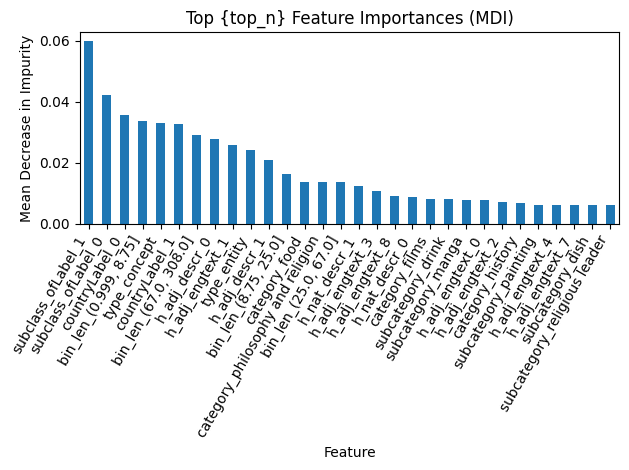

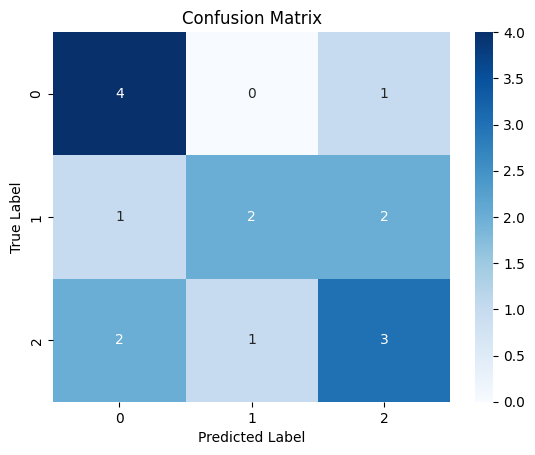

In [844]:
#ANALITICS WITH TOP IMPORTANT FEATURES
#I get feature names + feature importances
feature_names = X_train.columns.tolist()
importances = forest.feature_importances_
std = np.std([importances for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
top_n = 30
#Sort feature importances
top_features = forest_importances.sort_values(ascending=False).head(top_n)

fig, ax = plt.subplots()
top_features.plot.bar(yerr=std[[feature_names.index(f) for f in top_features.index]], ax=ax)
ax.set_title("Top {top_n} Feature Importances (MDI)")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Feature")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()